# 27) Generating Gaussians

In [3]:
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt

## Auxillary Functions 

In order of appearance: 

1) Importance sampling (to generate the weights) <br> 
2) Sample Variance (for checking implementations and for later part) <br>
3) Sample Mean (for checking implementations) 

In [4]:
def importance_sampling_gauss(n, sigma): 
    '''
    params: 
        n - int, number of samples to generate 
        sigma - int, standard deviation 
    returns: 
        np.array of length n 
    '''
    x = np.random.normal(size = n)
    pi_t_y = stats.norm.pdf(x, scale = sigma)
    pi_y = stats.norm.pdf(x)
    
    w = pi_y / pi_t_y 
    w_norm = w / np.sum(w) 
    return np.array( [x, w_norm] )


def calc_sample_var_multi(X):
    ''' 
    Does what title says. Assumes expected values are known. 
    params: 
        X - 2d (n x p) np.matrix with X[:, j] as samples from distribution X_j 
    return: 
        vars - array-like of length p representing estimated variances for each 
    '''
    p = X.shape[1] #num columns 
    var = []
    for j in range(p): 
        resamples_j = np.squeeze(np.asarray(X[:, j]))
        var.append( np.var(resamples_j))
    return var

def calc_sample_average(X): 
    '''
    params: 
        X - nxp np.matrix where column j is sampled from distribution j 
    returns: 
        x_bar - np array of length p where each element j corresponds to mean of column j of X 
    '''
    p = X.shape[1] #num columns 
    x_bar = []
    for j in range(p): 
        resamples_j = np.squeeze(np.asarray(X[:, j]))
        x_bar.append( np.mean(resamples_j))
    return x_bar
    

## Resampling Implementations 

The four used are <br>
1) Multinomial  
2) Bernoulli <br>
3) Stratified <br>
4) Systematic <br>

### Multinomial 

In [5]:
def resample_gauss_multinom(weights, l):
    '''
    Using multinomial resampling to sample copy numbers N_k from set W of size n.  
    params: 
        weights - np.array of length n, s.t. sum(weights) = 1
        l - int, number of times to resample (for calculating variances I suppose) 
            Note that each l means sampling n * l times from the multinomial distribution 
    returns: 
        np.matrix n x l where each index [i,j] contains copy number sample i of sample x_j with weight w_j 
    '''
    resamples = []
    for i in range(l):
        resamples.append( np.random.multinomial( len(weights), weights) ) 
    return np.matrix( resamples )  


In [6]:
#Just a quick visual check 
n_samples = 10
sigma = 2
X = importance_sampling_gauss(n_samples, 2) 
weights = np.sort( X[1, :] )  
expected = weights * n_samples #the expected value of the copy numbers given the weights, E[N_k]

l = 2000 #number of draws from resampling scheme distribution 
w_resample = resample_gauss_multinom(weights, l) #N_k  

In [7]:
mu = n_samples * weights 
est_var_multinom = calc_sample_var_multi(X = w_resample)
var_multinom = n_samples * weights * ( 1 - weights)
print(var_multinom)
print(est_var_multinom)

[ 0.08310904  0.55415976  0.72980481  0.98276946  0.98574996  1.02873341
  1.08290275  1.11411569  1.12105486  1.17324302]
[0.073949749999999995, 0.51213775000000006, 0.68767975000000003, 0.95178775000000004, 1.006359, 1.0687749999999998, 1.1154710000000001, 1.10272975, 1.1616897500000001, 1.2420359999999999]


### Bernoulli Resampling) 

In [88]:
def resample_bernoulli(weights, l): 
    '''
    Generates new copy numbers N_k using Bernoilli Resampling technique 
    params: 
        weights - np array
        l - number of draws 
    returns: 
         np.matrix n x l where each index [i,j] contains copy number sample i of sample x_j with weight w_j 
    '''
    n = len(weights)
    NW = n * weights
    NW_floor = NW.astype(int)
    
    resamples = [] 
    for i in range(l):
        u = np.random.uniform(size = n)
        cond = (u <  NW - NW_floor)
        resamples.append( NW_floor + cond ) 
    return np.matrix( resamples ) 

In [95]:
w_resample_bernoulli = resample_bernoulli(weights, l)
print("Estimated variances\n", np.round( calc_sample_var_multi(X = w_resample_bernoulli), decimals=3) )
var_resample_bernoulli = (mu - np.floor(mu)) * (np.ceil(mu) - mu)
print("True Variances\n", np.round( var_resample_bernoulli, decimals = 3) )

Estimated variances
 [ 0.041  0.068  0.095  0.111  0.134  0.166  0.17   0.195  0.208  0.205
  0.21   0.232  0.239  0.248  0.242  0.24   0.232  0.229  0.223  0.22
  0.221  0.201  0.206  0.191  0.166  0.137  0.146  0.128  0.102  0.104
  0.09   0.058  0.069  0.062  0.039  0.039  0.027  0.012  0.006  0.018
  0.027  0.038  0.047  0.048  0.057  0.054  0.066  0.079  0.085  0.093
  0.085  0.094  0.12   0.129  0.122  0.15   0.152  0.146  0.148  0.157
  0.159  0.165  0.168  0.174  0.184  0.2    0.207  0.205  0.208  0.214
  0.222  0.217  0.23   0.215  0.226  0.225  0.225  0.223  0.22   0.222
  0.223  0.226  0.222  0.228  0.219  0.226  0.232  0.232  0.234  0.234
  0.234  0.231  0.233  0.235  0.228  0.234  0.233  0.233  0.234  0.231]
True Variances
 [ 0.044  0.069  0.1    0.113  0.133  0.169  0.174  0.196  0.208  0.209
  0.21   0.228  0.241  0.248  0.24   0.238  0.228  0.227  0.227  0.216
  0.209  0.207  0.204  0.2    0.159  0.144  0.143  0.133  0.104  0.097
  0.082  0.071  0.068  0.058  0.04   0.0

### Stratified Resampling 

In [10]:
def get_ranges(weights): 
    '''
    params: 
        weights - np array of length n representing sample weights 
    returns: 
        np array of length n where each element i contains sum(weights_j) for j <= i
    '''    
    thresholds = [] 
    cur = 0 
    for w in weights:
        cur += w
        thresholds.append(cur)
    return thresholds 

def count_points(thresholds, u): 
    '''
    params: 
       thresholds - np array of length n representing cumulative sums of weights up to element i 
       u - sorted np array of length, presumably generated from stratas 
    returns: 
        np array of length n where each element i represents the copy count, 
            here it is the number of points that fall between 
            thresholds[i - 1] and thresholds[i]
    '''
    j = 0 #iterator through u  
    N_k = [] 
    count = 0 
    for bound in thresholds: 
        #print("bound: {}".format(bound))
        while j < len(u): 
            #print("u[j]: {}".format(u[j]))
            if bound > u[j]: 
                #print("Yes! u[j] ({}) < bound ({})".format(u[j], bound))
                count += 1
                j += 1 
            else: 
                #print("No. u[j] ({}) > bound ({})".format(u[j], bound))
                N_k.append(count)
                count = 0
                break

    #print("count after: {}".format( count) ) 
    #now we need to fill in rest of the spots in N_k 
    N_k.append(count)
    while len(N_k) < len(u): 
        N_k.append(0)
    return N_k 


def resample_stratified(weights, l): 
    '''
    Generates new copy numbers N_k using Stratified Resampling technique 
    params: 
        weights - np array 
        l - number of draws 
    returns: 
         np.matrix n x l where each index [i,j] contains copy number sample i of sample x_j with weight w_j 
    '''
    thresholds = get_ranges(weights)
        
    resamples = [] 
    n = len(weights)
    for i in range(l):
        u = []
        for j in range(n): #draw uniformally from each strata 
            u.append( np.random.uniform(low = j / n, high = (j + 1) / n) ) 
        N_i = count_points(thresholds, u)
        
        resamples.append( N_i ) 
    #print(len(resamples))
    #print(len(N_i))
    return np.matrix( resamples ) 

In [11]:
resample_strata = resample_stratified(weights, l)
#strata_xbars = calc_sample_average(resample_strata)
#print(strata_xbars - expected)
#print(expected)

### Systematic Resampling 

In [12]:
def resample_systematic(weights, l): 
    '''
    Generates new copy numbers N_k using the Systematic Resampling technique 
    params: 
        weights - np array
        l - number of draws 
    returns: 
         np.matrix n x l where each index [i,j] contains copy number sample i of sample x_j with weight w_j 
    '''
    n = len(weights)
    thresholds = get_ranges(weights)
    intervals = np.array( range(n) ) / n
    
    resamples = [] 
    
    for i in range(l):
        u = np.random.uniform(high = 1 / n ) + intervals
        N_i = count_points(thresholds, u)
        resamples.append( N_i ) 
    return np.matrix( resamples )     

In [13]:
resample_sys = resample_systematic(weights, l)
resample_sys.shape
#sys_xbar = calc_sample_average(resample_sys)
#print( sys_xbar - expected ) 

(2000, 10)

## Observing the sample variances 

We shall test the sample variances for l = 2000 resamples for n = 100 Importance samples (So we are actually drawing 2000 * 100 in total) for $\sigma =  \{0.1, 0.4, 0.7, 0.9, 1, 1.1, 1.5, 3, 8\}$


In [14]:
sigmas = [0.1, 0.4, 0.7, 0.9, 1, 1.1, 1.5, 3, 8]
n_samples = 100
l = 2000 #number of draws from resampling scheme distribution


variances = {'multinom' : [], 'bernoulli': [], 'stratified' : [], 'systematic' : []} 
for sigma in sigmas: 
    X = importance_sampling_gauss(n_samples, sigma) 
    weights = np.sort( X[1, :] ) 
    mu = weights * n_samples #the expected value of the copy numbers given the weights, E[N_k]
    
    multinom_resample = resample_gauss_multinom(weights, l) #N_k
    multinom_vars = calc_sample_var_multi(multinom_resample)
    variances['multinom'].append(multinom_vars)
    
    bernoulli_resample = resample_bernoulli(weights, l)
    bernoulli_vars = calc_sample_var_multi(bernoulli_resample)
    variances['bernoulli'].append(bernoulli_vars)

    stratified_resample = resample_stratified(weights, l)
    stratified_vars = calc_sample_var_multi(stratified_resample)
    variances['stratified'].append(stratified_vars)

    sys_resample = resample_systematic(weights, l)
    sys_vars = calc_sample_var_multi(sys_resample)
    variances['systematic'].append(sys_vars)


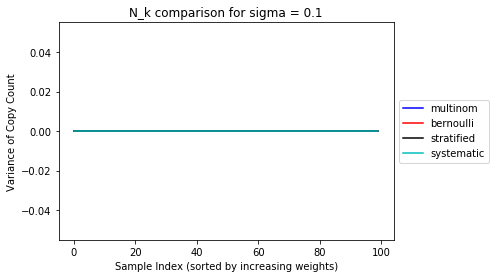

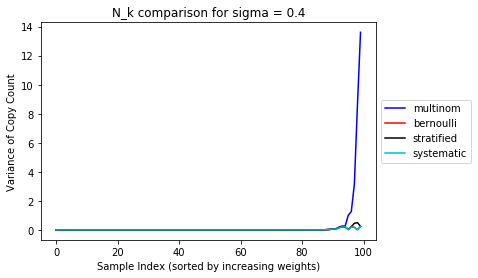

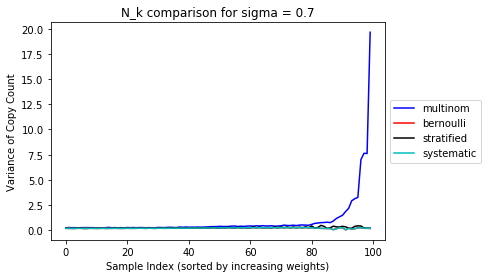

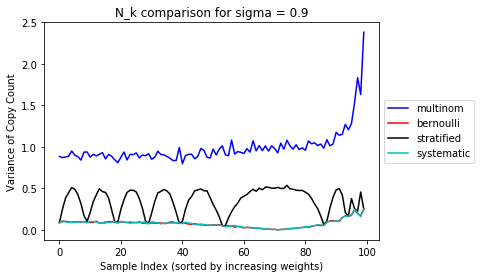

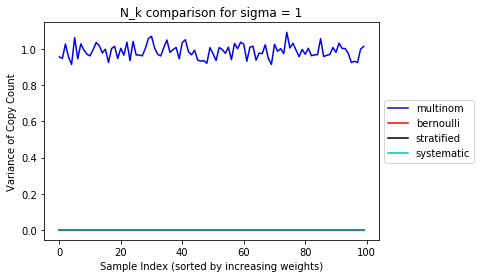

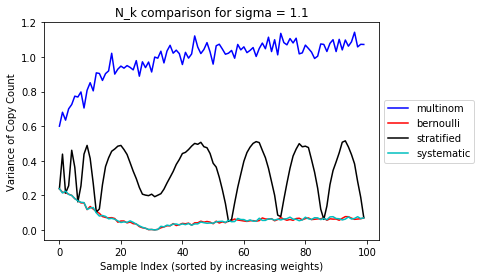

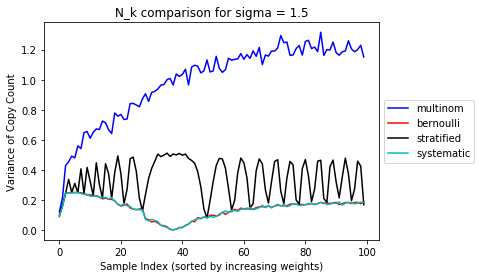

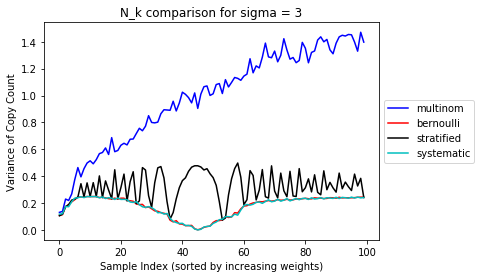

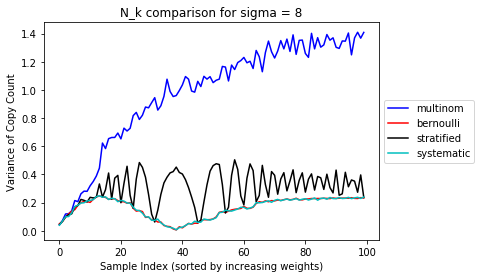

In [15]:
indices = list(range(n_samples)) 
cols = ['b-', 'r-', 'k-', 'c-']
schemes = variances.keys()

for i in range(len(sigmas)): 
    sigma = sigmas[i]
    title = "N_k comparison for sigma = {}".format(sigma)
    lines = [] 
    for j, k in enumerate(schemes):
        line, = plt.plot( indices, variances[k][i], cols[j])
        lines.append( line )
    plt.legend(lines, list(schemes), bbox_to_anchor = (1, 0.5), loc = 'center left' )
    plt.title(title)
    
    plt.xlabel('Sample Index (sorted by increasing weights)')
    plt.ylabel('Variance of Copy Count')
    plt.show()

For small values of $\sigma$ (eg. 0.1), the variances for the copy numbers are all basically 0. As we increase sigma to 0.4 and 0.7, we see crazy spikes in the variances for the copy numbers drawn from the mulitnomial with higher weights, while the other three methods are relatively stable. As $\sigma = 1$, (the sanity check case, where all weights are equal) we see that only the multinomial has a clear nonzero variance. For $\sigma$ above 1, multinomial is always the highest variance, with increasing variance as the weights for the samples increase. We start to see that the stratified method also breaks away from the pack, where the variance oscillates as the weights increase. Systematic and Stratified consistenly remain low. Note that for $\sigma > 1$, the variances for all methods appear to cap out. Therefore, our observations are robust to change $\sigma$, except for the multinomial case when $\sigma < 1 $. 

# 28 Self Avoiding Random Walk 

Below we define some helper functions that will be used to sample from SAW(d), along with some test cases. 

In [16]:
def get_neighbors(loc, L): 
    '''
    params: 
        loc - array like (x,y) representing current location of agent on lattice 
        L - length of lattice
    returns: 
        np array [up, down, left, right] of points that are the neighbors of loc
    '''
    if loc[0] < 0 or loc[0] > L - 1: 
        print("FATAL: x coordinate out of bounds")
    if loc[1] < 0 or loc[1] > L - 1: 
        print("FATAL: y coordinate out of bounds")
    
    if loc[0] == 0:
        left = np.array([L-1, loc[1]])
    else: 
        left = np.array([loc[0] - 1, loc[1]])
        
    if loc[0] == L - 1: 
        right = np.array([0, loc[1] ])
    else: 
        right = np.array([loc[0] + 1, loc[1]])
    
    if loc[1] == 0: 
        down = np.array( [ loc[0], L - 1 ] )
    else: 
        down = np.array( [ loc[0], loc[1] - 1 ])
        
    if loc[1] == L - 1:
        up = np.array( [loc[0], 0])
    else: 
        up = np.array( [loc[0], loc[1] + 1 ])
        
    return [up, down, left, right]

print("Testing Neighbors Function: \n")
print( "expected: (1,3), (1,1), (0, 2), (2, 2) \t| actual: {}".format( get_neighbors( (1,2), 10 ) ) )  
print( "expected: (9,0), (9,8), (8, 9), (0, 9) \t| actual: {}".format( get_neighbors( (9,9), 10 ) ) )  
print( "expected: (0,1), (0,9), (9, 0), (1, 0) \t| actual: {}".format( get_neighbors( (0,0), 10 ) ) )  
print( "expected: (0,6), (0,4), (9, 5), (1, 5) \t| actual: {}".format( get_neighbors( (0,5), 10 ) ) )  

def get_valid_neighbors(points, L): 
    '''
    gets neighbors, and removes points that were previously on 
    returns: 
        list of coordinates of valid next steps
    '''
    loc = points[len(points) - 1]
    neighbors = get_neighbors(loc, L)
    for p in points: 
        for i, n in enumerate( neighbors ): 
            if p[0] == n[0] and p[1] == n[1]:
                neighbors.pop(i)
    return neighbors 
    
print("\nTesting Valid Neighbors\n")
points = [(0,0), (1,1), (0,2), (0,1)]
print("expected: (9,1) \t|actual: {}".format(get_valid_neighbors(points, L=10) ) )
points2 = [(0,0), (9,1), (1,1), (0,2), (0,1)]
print("expected: () \t|actual: {}".format(get_valid_neighbors(points2, L=10)))
print("expected: {} \t|actual: {}".format(get_neighbors((5,5), L= 10), get_valid_neighbors([(5,5)], L=10)))

def next_step(points, L): 
    '''
    takes a step according to SAW
    params: 
        points - np array containing all the points the walk has been through, with the first step at index 0 
        L - length of lattice
    returns: 
        np array (x,y) representing the next point on the SAW 
    '''
    valid = get_valid_neighbors(points, L)
    i = np.random.choice(list(range(len(valid))))
    return valid[i]


Testing Neighbors Function: 

expected: (1,3), (1,1), (0, 2), (2, 2) 	| actual: [array([1, 3]), array([1, 1]), array([0, 2]), array([2, 2])]
expected: (9,0), (9,8), (8, 9), (0, 9) 	| actual: [array([9, 0]), array([9, 8]), array([8, 9]), array([0, 9])]
expected: (0,1), (0,9), (9, 0), (1, 0) 	| actual: [array([0, 1]), array([0, 9]), array([9, 0]), array([1, 0])]
expected: (0,6), (0,4), (9, 5), (1, 5) 	| actual: [array([0, 6]), array([0, 4]), array([9, 5]), array([1, 5])]

Testing Valid Neighbors

expected: (9,1) 	|actual: [array([9, 1])]
expected: () 	|actual: []
expected: [array([5, 6]), array([5, 4]), array([4, 5]), array([6, 5])] 	|actual: [array([5, 6]), array([5, 4]), array([4, 5]), array([6, 5])]


In [292]:
def seqential_sampling_saw(n, d, L, method): 
    '''
    SAW(d). Steps: 
        1) Start all samples at random point on l x l lattice (0, l - 1} , with initial weight 1/N for all samples  
        2) Repeat until d steps: 
            a) Take step, update weights with weight factor w_{n-1} ~ m_{n-1} = | {x_n : x_1:n in SAW(n)} |  
            b) Resample 
            
    params: 
        n - int, number of samples 
        d - int, length of the walk 
        L - int, length of the lattice
        method - a function that takes in a weight vector and uses a resampling scheme to give a copy number for each 
                    weight. (AKA one of resampling functions I defined above)
    returns: 
        a np array of length d representing the estimated exp. value obtained importance sampling 
    '''
    
    samples = [] #list of list (point of walk) of tuples (x,y <- the points on the walk) 
    #tmp_weights = weights 
    
    for i in range(n): 
        samples.append( [ np.random.choice(range(L), size = 2 ) ] ) #each sample randomly starts in lattice 
        
    ns = len(samples)
    for s in range(d): 
        tmp_weights = [] #list for the weights of each point
        for i in range(ns): #append the next step
            print(samples[i])
            valid = get_valid_neighbors( samples[i], L)
            m = len(valid) #number of points avaliable in the next step
            if m: 
                index_next = np.random.choice(list(range(len(valid))))
                samples[i].append( valid[index_next] ) #each sampled walk takes a step 
                tmp_weights.append( m )
            else: 
                tmp_weights.append( 0 ) #no points avalaible. Add weight of 0. 

        #resampling 
        tmp_weights = tmp_weights / np.sum(tmp_weights)
        cpy_matrix = method(tmp_weights, 2)
        copy_numbers = np.squeeze( np.asarray( cpy_matrix ) ) #resampling time   
        print("Copy numbers: {} {}".format( copy_numbers, type(copy_numbers) ) ) 
        if len(copy_numbers) == 1: 
            
        tmp_samples = []
        for i, cn in enumerate(copy_numbers):
            for j in range(cn): 
                tmp_samples.append( list( samples[i] ) )
        samples = tmp_samples 
        ns = len(samples)
        tmp_weights
        print("Sample Length at step {}: {}".format(s, ns))
        
    return samples
            

In [293]:
L = 20
d = 10
n = 1
walks = seqential_sampling_saw(n, d, L, resample_bernoulli) 
for walk in walks: 
    print(walk)

[array([18, 19])]
(2, 1)
Copy numbers: [1 1] <class 'numpy.ndarray'>


IndexError: list index out of range

In [287]:
matrix = np.matrix([ [1,2], [3,4] ])
np.squeeze( np.asarray(matrix[:, 1]) )

array([2, 4])

In [ ]:
def add(a): 
    return a + 1
def add2(a, func):
    return func(a) + 1
resample_strata = resample_stratified(weights, 1)
print( resample_strata.shape ) 
np.squeeze(np.asarray(resample_strata[0, :]))
a = [[1,2]] * 3
a.append(a)
a